<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4206_202410_AML/blob/main/Laboratorios/Laboratorio%202/Sesión%203%20Extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

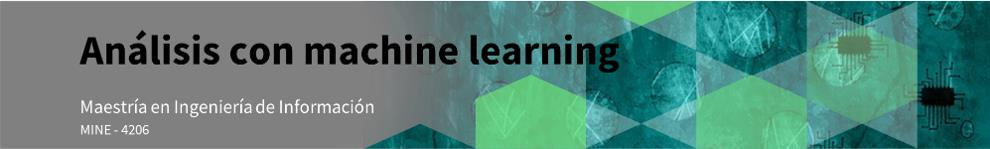

**Tutores**
- Nicolás Tibatá Castañeda.
- Fabián Camilo Castellanos P.

#Tabla de contenido

[Contexto.](#scrollTo=jXKiW9SKAF41)<br>
[0. Instalación de librerías.](#scrollTo=7sc7X5ADLmdQ)<br>
[1. Introducción a los datos.](#scrollTo=c_tbf9j-cHUY)<br>
[2. Modelamiento.](#scrollTo=JGvrxMMvcHUb)<br>
[3. PCA.](#scrollTo=jjtmgOrqcHUc)<br>
[4. Preguntas.](#scrollTo=sfcrl3pwcHUd)<br>


---
## **Contexto**
- En este caso exploraremos el dataset "Cat & Dog". Este dataset cuenta con 24000 imágenes. Las imágenes presentan diversas dimensiones, siendo 100x100 la más común. El objetivo es construir un clasificador a través del algoritmo de KNN que pueda distinguir entre cada uno de estos alimentos.

## **Objetivos**
- Familiarizarse con las librerías de Scikit-Learn y con el algoritmo de KNN
- Resolver un problema de clasificación y tomar métricas de desempeño sobre este
- Entender cómo funciona la reducción de dimensionalidad con PCA y cómo se puede aplicar a un problema de clasificación

Datos: [Cat & Dog](https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification/data)

# 0. Instalación de Librerías

In [1]:
!pip install kaggle --quiet

In [2]:
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from google.colab import files

from scipy.stats import wasserstein_distance # Distancia de Wasserstein para comparar histogramas

from skimage import exposure # Algoritmos de ecualización de histogramas
from skimage.io import imread # Lectura de imágenes
from skimage.transform import resize # Redimensionamiento de imágenes
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier # Clasificador KNN
from sklearn.model_selection import train_test_split, GridSearchCV # Búsqueda de hiperparámetros
from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.decomposition import PCA # Análisis de componentes principales
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión

# 1. Introducción a los datos

**Debido a que el dataset es relativamente pesado ~500MB, los traeremos directo de Kaggle.**

Puedes ver [aquí](https://www.kaggle.com/discussions/general/74235) sobre cómo cargar datos directamente de kaggle.

In [3]:
files.upload() #Kaggle.json (API)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nicolastibataa","key":"45b773c5f054c5ed3e70d014009f5f5c"}'}

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list #Correr este comando verifica que esta bien montado el driver de kaggle

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                              title                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------  ----------------------------------  -----  -------------------  -------------  ---------  ---------------  
zain280/car-dataset                              Car Dataset                           1MB  2024-03-02 15:14:49           1658         25  1.0              
syedanwarafridi/vehicle-sales-data               Vehicle Sales Data                   19MB  2024-02-21 20:16:17           7912        138  1.0              
mahad049/job-placement-dataset                   Job placement dataset                 6KB  2024-03-03 08:18:12            982         25  0.9411765        
yaminh/smartphone-sale-dataset                   Smartphones Sales Dataset            65KB  2024-03-03 16:48:27           1066         22  0.88235295     

In [5]:
!kaggle datasets download ashfakyeafi/cat-dog-images-for-classification

 99% 537M/545M [00:09<00:00, 61.6MB/s]
100% 545M/545M [00:09<00:00, 60.3MB/s]


In [6]:
ROOT_DIR = '/content'
DATASET_NAME = 'cat-dog-images-for-classification'

In [7]:
%cd {ROOT_DIR}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

Streaming output truncated to the last 5000 lines.
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5499.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.55.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.550.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5500.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5501.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5502.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5503.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5504.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5505.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5506.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5507.jpg  
  inflating: /content/cat-dog-images-for-classification/cat_dog/dog.5508.jpg  
  in

In [8]:
df = pd.read_csv("/content/cat-dog-images-for-classification/cat_dog.csv")
df.head()
#dog = 1 & cat = 0

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   25000 non-null  object
 1   labels  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


(352, 349, 3)


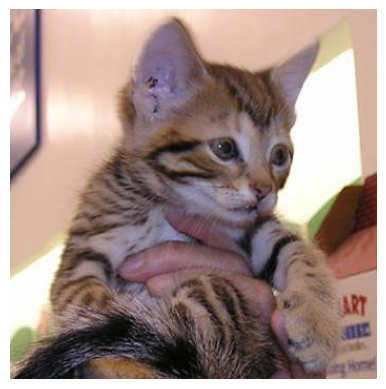

In [10]:
img = imread("/content/cat-dog-images-for-classification/cat_dog/cat.12461.jpg")
plt.imshow(img)
print(img.shape)
plt.axis('off')
plt.show()
# Qué significa el 3?

## 1.1. Preparación de los Datos

In [11]:
# Realizamos split de train y test al 80%
sample_df = df.sample(frac=0.025, random_state=19)
train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=19)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

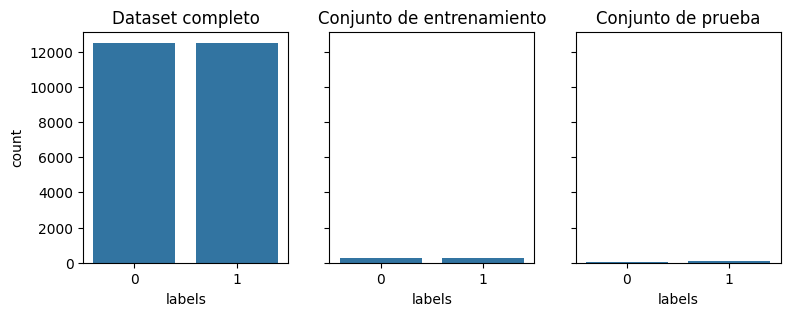

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(9, 3))
sns.countplot(x='labels',data=df, ax=ax[0])
ax[0].set_title('Dataset completo')
sns.countplot(x='labels',data=train_df, ax=ax[1])
ax[1].set_title('Conjunto de entrenamiento')
sns.countplot(x='labels',data=test_df, ax=ax[2])
ax[2].set_title('Conjunto de prueba')
plt.show()

In [13]:
# Redimensionamos las imagenes a 100x100 en una misma escala para poderlas normalizar
temp = []
for img_name in train_df.image:
    img_path = os.path.join("/content/cat-dog-images-for-classification/cat_dog", img_name)
    img = imread(img_path)
    img = resize(img, (100, 100), anti_aliasing=True)
    temp.append(np.array(img))

train_x = np.stack(temp)

In [14]:
# Redimensionamos las imagenes a 100x100 en una misma escala para poderlas normalizar
temp = []
for img_name in test_df.image:
    img_path = os.path.join("/content/cat-dog-images-for-classification/cat_dog", img_name)
    img = imread(img_path)
    img = resize(img, (100, 100), anti_aliasing=True)
    temp.append(np.array(img))

test_x = np.stack(temp)

**Normalizar los datos:**

Vamos a normalizar el valor de los pixeles de las imágenes en el rango [0,1]. Al tener una escala uniforme el modelo converge más rápido y puede aumentar el rendimiento al evitar que ciertas características dominen otras.

In [15]:
x_train = train_x.astype('float32') / 255.0
x_test = test_x.astype('float32') / 255.0

# 2. Modelamiento

En esta sección, emplearemos el algoritmo K-Nearest Neighbors (KNN) para nuestro problema de clasificación de imágenes. KNN es un algoritmo basado en instancia que clasifica una imagen según la mayoría de clases en sus K imágenes vecinas más cercanas en el espacio de características.

En el contexto de este problema (clasificación de perros y gatos) la simplicidad de KNN nos permite comparar las caracteristicas de las imágenes de una manera intuitiva.

##### K-Nearest-Neighbors

<img src="https://miro.medium.com/max/3544/1*4F-q86XFr2-EsaAcz0Zu5A.png" width="800" />

> Tomado de [Towards Data Science](https://towardsdatascience.com/k-nearest-neighbor-python-2fccc47d2a55)

##### Consideración

Debemos tener en cuenta que KNN no puede procesar imágenes directamente. Las imágenes deben ser transformadas en vectores de características. Una forma común es aplanar cada imagen en un vector unidimensional. Por ejemplo, una imagen de 100x100x3 se convierte en un vector de 30000 elementos.

In [16]:
# Aplanamiento de las imágenes
x_train_flatten = np.array([img.flatten() for img in x_train])
x_test_flatten = np.array([img.flatten() for img in x_test])

In [17]:
# Tamaño del vector unidimensional
print(x_train_flatten.shape)

(500, 30000)


No hemos definido nuestros y_train y y_test

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   500 non-null    object
 1   labels  500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [19]:
y_train = train_df.labels
y_test = test_df.labels

Ahora vamos a desarrollar una cuadrícula para encontrar los mejores parámetros posibles a nuestro modelo.

In [20]:
start = time.time()

param_grid = {
    'n_neighbors': np.arange(2, 6, 15),
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan']
}

# Crear la instancia de GridSearchCV (Grilla de búsqueda)
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="accuracy", # Nos concentraremos en la exactitud (cuántas predicciones son correctas)
                           cv=6, return_train_score=True)

# Entrenar el modelo
grid_search.fit(x_train_flatten, y_train)

end = time.time()

print("Tiempo de entrenamiento: {:.2f} segundos".format(end - start))

Tiempo de entrenamiento: 62.75 segundos


In [21]:
print("Mejor precisión: ", grid_search.best_score_)
print("Mejores parámetros: ", grid_search.best_params_)

Mejor precisión:  0.5699464524765729
Mejores parámetros:  {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}


Matriz de confusión datos de entrenamiento


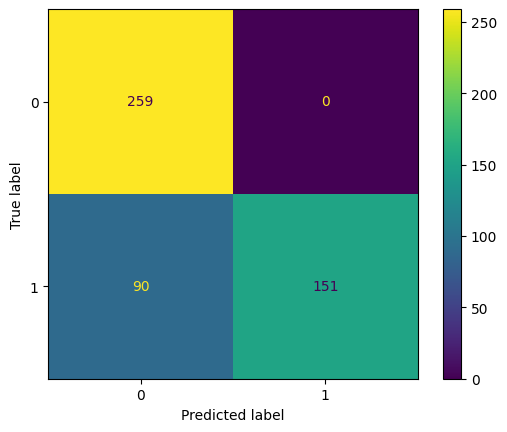

In [22]:
unique_train = np.unique(y_train)
print("Matriz de confusión datos de entrenamiento")

# Matriz de confusión para entrenamiento
cm = confusion_matrix(y_train, grid_search.best_estimator_.predict(x_train_flatten))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_train)
disp.plot()

In [23]:
# Mejor modelo
best_model = grid_search.best_estimator_
# Predecir
y_pred = best_model.predict(x_test_flatten)
# Exactitud
print("Exactitud: ", accuracy_score(y_test, y_pred))

Exactitud:  0.48


Matriz de confusión datos de test


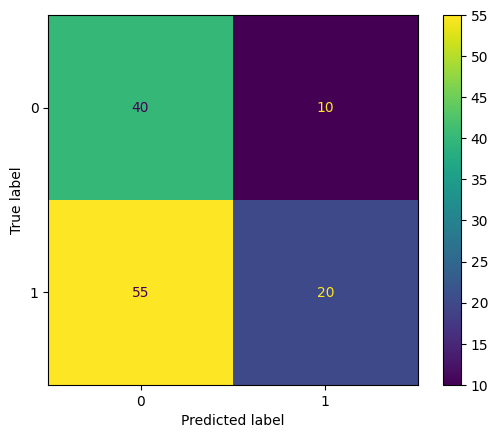

In [24]:
unique_test = np.unique(y_test)
print("Matriz de confusión datos de test")

# Matriz de confusión para test
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_test)
disp.plot()

No hay valores optimos de predicción. ¿Qué se puede hacer para mejorar el desempeño del modelo? ¿Algún otro modelo podría funcionar mejor?

# 3. PCA

PCA es una técnica de reducción de dimensionalidad. PCA identifica las direcciones en las cuales los datos varían más y proyecta los datos en un espacio de menor dimensión, reteniendo la mayor cantidad de información posible. Al reducir la dimensionalidad, PCA permite que KNN opere en un espacio de características más manejable, mejorando potencialmente la velocidad y el rendimiento del modelo.

PCA requiere que los datos estén en un formato bidimensional donde cada fila es una muestra y cada columna es una característica. Nuestras imágenes Tienen que ser aplanadas en un vector unidimensional para poder aplicar PCA. por lo que podemos usar X_train_flat y X_test_flat.

In [25]:
# Aplicar PCA
pca = PCA(0.95) # Queremos conservar el 95% de la varianza
x_train_pca = pca.fit_transform(x_train_flatten)
x_test_pca = pca.transform(x_test_flatten)

In [26]:
start = time.time()

# Crear la instancia de GridSearchCV (Grilla de búsqueda)
param_grid = {
    'n_neighbors': np.arange(2, 6, 15),
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=6, return_train_score=True)

grid_search.fit(x_train_pca, y_train)

end = time.time()

print("Tiempo de entrenamiento: {:.2f} segundos".format(end - start))

Tiempo de entrenamiento: 0.67 segundos


In [27]:
print("Mejor precisión: ", grid_search.best_score_)
print("Mejores parámetros: ", grid_search.best_params_)

Mejor precisión:  0.5680818512143814
Mejores parámetros:  {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}


Matriz de confusión datos de entrenamiento


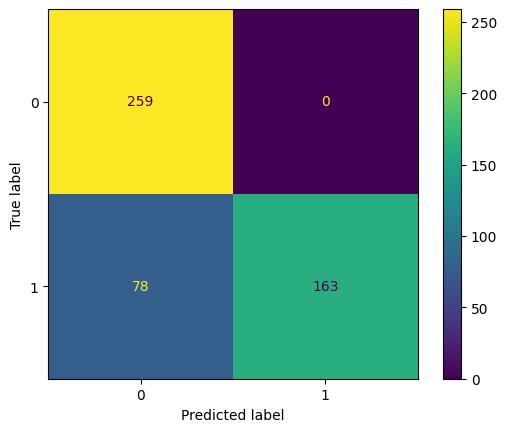

In [28]:
print("Matriz de confusión datos de entrenamiento")

# Matriz de confusión para entrenamiento
cm = confusion_matrix(y_train, grid_search.best_estimator_.predict(x_train_pca))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_train)
disp.plot()

In [29]:
# Mejor modelo
best_model = grid_search.best_estimator_
# Predecir
y_pred = best_model.predict(x_test_pca)
# Exactitud
print("Exactitud: ", accuracy_score(y_test, y_pred))

Exactitud:  0.52


Matriz de confusión datos de test


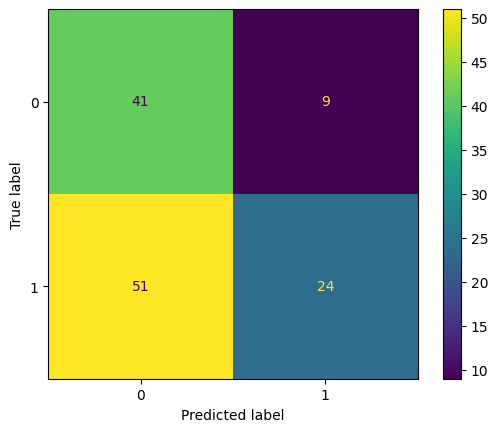

In [30]:
print("Matriz de confusión datos de test")

# Matriz de confusión para test
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_test)
disp.plot()

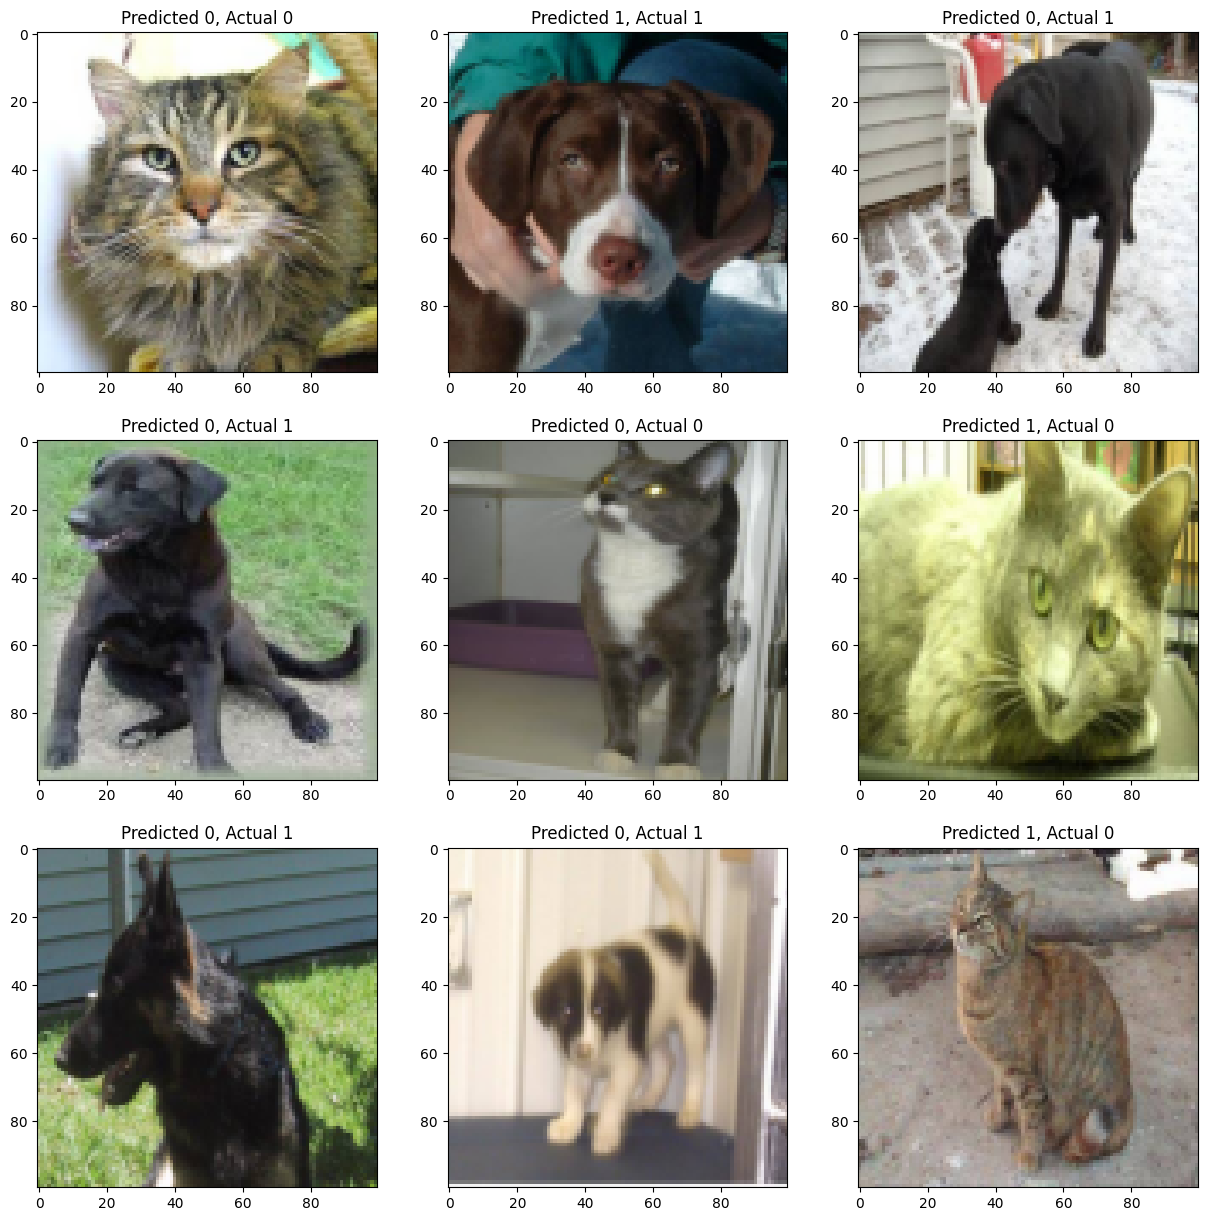

In [31]:
plt.figure(figsize=(15,15))
for i in range(0, min(len(y_pred), 9)):
    # Seleccionar un índice aleatorio
    idx = np.random.randint(0, len(y_pred))

    # Mostrar imagen
    plt.subplot(3,3, i+1)
    plt.imshow(x_test[idx].reshape(100,100,3)*255.0, cmap='gray')
    plt.title(f"Predicted {y_pred[idx]}, Actual {y_test[idx]}")
plt.show()

La diferencia en las métricas de desempeño entre el modelo entrenado con datos originales y el modelo entrenado con datos transformados por PCA no es significativa. Sin embargo, se observa una notable reducción en el tiempo de entrenamiento del modelo, pasando de 62.7s a 0.67s. PCA permite conservar la esencia de la información en un espacio de menor dimensión, lo cual es beneficioso al trabajar con datos de alta dimensionalidad como las imágenes.

# 4. Preguntas

1. ¿Qué pasa si se cambia el tamaño de las imágenes? ¿Se puede mejorar el desempeño del modelo?. Podemos probar aumentando o disminuyendo el ancho y alto de las mismas. Recordemos que hay imágenes que son de mayor calidad que otras.
2. Si las imágenes se leyeran en escala de grises ¿Podrían resolverse problemas de clasificación entre las clases manzana y tomate principalmente asociados al color?